# Analyze A/B Test Results

## Introduction

As a data analyst, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


## 1. Initial exploration 

In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(2)

In [2]:
ab = pd.read_csv('/Users/jasminechen/Downloads/AB-Testing-A-New-Webpage/ab_data.csv')
ab.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [3]:
# find out the number of records in the dataset
ab.shape

(294478, 5)

In [13]:
# missing values
ab.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [14]:
# records where the new_page and control don't line up
ab_1 = ab[(ab.group == 'control') & (ab.landing_page == 'new_page')]
ab_1.count()

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64

In [15]:
# records where the old_page and treatment don't line up
ab_2 = ab[(ab.group == 'treatment') & (ab.landing_page == 'old_page')]
ab_2.count()

user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64

In [16]:
# total number of records that don't line up
ab_1.count() + ab_2.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [17]:
# subset the records which line up 
new_1 = ab[(ab.group == 'control') & (ab.landing_page == 'old_page')]
new_2 = ab[(ab.group == 'treatment') & (ab.landing_page == 'new_page')]
df2 = pd.concat([new_1,new_2], keys=['control','treatment'], axis = 0)
df2.reset_index(drop=True)


,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,864975,52:26.2,control,old_page,1
3,936923,20:49.1,control,old_page,0
4,719014,48:29.5,control,old_page,0
...,...,...,...,...,...
290580,677163,41:51.9,treatment,new_page,0
290581,925675,38:26.3,treatment,new_page,0
290582,643562,20:05.5,treatment,new_page,0
290583,822004,36:46.1,treatment,new_page,0


In [18]:
# investigate duplicates
df2['user_id'].nunique()

290584

In [19]:
df2[df2.duplicated(subset = ['user_id'], keep=False)]

user_id timestamp      group landing_page  converted
treatment 1899   773192   37:58.8  treatment     new_page          0
          2893   773192   55:59.6  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [20]:
# remove duplicates
df2 = df2.drop_duplicates(subset = ['user_id'],keep = 'last')
df2

user_id timestamp      group landing_page  converted
control   0        851104   11:48.6    control     old_page          0
          1        804228   01:45.2    control     old_page          0
          4        864975   52:26.2    control     old_page          1
          5        936923   20:49.1    control     old_page          0
          7        719014   48:29.5    control     old_page          0
...                   ...       ...        ...          ...        ...
treatment 294462   677163   41:51.9  treatment     new_page          0
          294465   925675   38:26.3  treatment     new_page          0
          294468   643562   20:05.5  treatment     new_page          0
          294472   822004   36:46.1  treatment     new_page          0
          294477   715931   40:24.5  treatment     new_page          0

[290584 rows x 5 columns]

In [21]:
# total conversion rate 
df2['converted'].mean()

0.11959708724499628

In [17]:
# control conversion rate 
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

In [22]:
# treatment conversion rate 
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

In [37]:
# calculate the probability that an individual received the new page
len(df2.query("landing_page == 'new_page'"))/len(df2)

0.5000619442226688

#### - The probability they converted is 0.118807 in the treatment group. The probability they converted is 0.120386 in the control group. 
####  - Old page has a slight higher conversion rate, by a very slim margin.
#### - Test span durations and external factors such as competitor performance are not accounted for. So, we cannot state with certainty that one page leads to more conversions. 

## 2. A/B Test

Because of the time stamp associated with each event, it's technically feasible to run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we run to render a decision that neither page is better than another? These questions are the difficult parts associated with A/B tests in general.  


First, I will draw insights just based on all the data provided.  I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

**Ho : P_old >= P_new **

**H1 : P_old < P_new **


I assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

In [41]:
# convert rate for  𝑝𝑛𝑒𝑤  under the null
Pnew = df2.converted.mean()
Pnew

0.11959708724499628

In [42]:
# convert rate for  𝑝𝑜𝑙𝑑  under the null
Pold = df2.converted.mean()
Pold

0.11959708724499628

In [38]:
# nnew
nnew = df2.query('landing_page == "new_page"').shape[0] 
nnew

145310

In [39]:
# nold
nold = df2.query('landing_page == "old_page"').shape[0] 
nold

145274

In [47]:
# Simulate 𝑛𝑛𝑒𝑤 transactions with a convert rate of  𝑝𝑛𝑒𝑤  under the null
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
# simulated new page conversion rate 
npc = new_page_converted.mean()
npc

0.1191796848117817

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [45]:
# Simulate  𝑛𝑜𝑙𝑑  transactions with a convert rate of  𝑝𝑜𝑙𝑑  under the null.
old_page_converted = np.random.binomial(1, Pold, nold)
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

In [46]:
# simulated old page conversion rate 
opc = old_page_converted.mean()
opc

0.12051709184024671

In [50]:
#simulated diff of pnew and pold
npc - opc

-0.001337407028465007

#### 2.1 Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [59]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, Pnew, nnew)
    old_page_converted = np.random.binomial(1, Pold, nold)
    npc = new_page_converted.mean()
    opc = old_page_converted.mean()
    diff = npc - opc
    p_diffs.append(diff)

#### Plot a histogram of the **p_diffs**

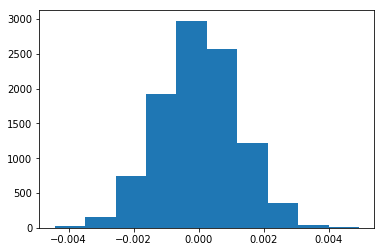

In [52]:
plt.hist(p_diffs);


j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [54]:
# compute the acutal difference from original dataset ab_data.csv
actual_diff=df2[df2['group'] == 'treatment']['converted'].mean()-df2[df2['group'] == 'control']['converted'].mean()
actual_diff

-0.0015782389853555567

#### Plot the actual diff in the p_diffs distribution

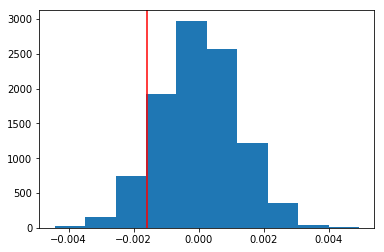

In [56]:
actual_diff= np.array(actual_diff).astype(float)
plt.hist(p_diffs);
plt.axvline(x=actual_diff, color='red');

In [58]:
# proportion of the p_diffs are greater than the actual difference observed 
(actual_diff < p_diffs).mean()

0.9034

#### Since the P-value is 0.9034, greater than alpha (0.05) or (0.01), it does not reject the null. It means that it is not scientifically significant. Therefore, we don't reject the null hypothesis that Pnew <= Pold 

#### 2.2 Built-in Function statsmodels.ap

In [63]:
import statsmodels.api as sm

#Get convert_new
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

#Get convert_old
convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]


In [66]:
# use stats.proportions_ztest to compute your test statistic and p-value.
count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])
z_score, p_value = sm.stats.proportions_ztest(count, nobs, alternative = 'smaller')
print('{0:0.4f}'.format(z_score))
print('{0:0.4f}'.format(p_value))

1.3109
0.9051


#### The p-value associated with a 95% confidence level is 0.05. If Z score is between -1.96 and +1.96, p-value will be larger than 0.05. Since p-value is 0.9051 and z-score is 1.3109, we cannot reject your null hypothsi

## 3. A regression approach

I will approach the problem using logistic regression.<br><br>

In [25]:
# create a colum for the intercept, and create a dummy variable column for which page each user received
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])
df2

user_id timestamp      group landing_page  converted  \
control   0        851104   11:48.6    control     old_page          0   
          1        804228   01:45.2    control     old_page          0   
          4        864975   52:26.2    control     old_page          1   
          5        936923   20:49.1    control     old_page          0   
          7        719014   48:29.5    control     old_page          0   
...                   ...       ...        ...          ...        ...   
treatment 294462   677163   41:51.9  treatment     new_page          0   
          294465   925675   38:26.3  treatment     new_page          0   
          294468   643562   20:05.5  treatment     new_page          0   
          294472   822004   36:46.1  treatment     new_page          0   
          294477   715931   40:24.5  treatment     new_page          0   

                  intercept  ab_page  
control   0               1        1  
          1               1        1  
          4               1        1  
          5               1        1  
          7               1        1  
...                     ...      ...  
treatment 294462          1        0  
          294465          1        0  
          294468          1        0  
          294472          1        0  
          294477          1        0  

[290584 rows x 7 columns]

In [26]:
import statsmodels.api as sm

/Users/jasminechen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [33]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [34]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        13:15:59   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0038      0.008   -247.146      0.000      -2.020      -1.988
ab_page        0.0150      0.011      1.311      0.190      -0.007       0.037
==============================================================================
"""

**Rejecting null value should be equal to or less than the alpha (0.05); therefore, it is scientifically significant. In this case, the p-value is equal 0.9021 or 90.21% chance of being p_diffs. If the p-value is greater than alpha (0.05) or (0.01), it does not reject the null. It means that it is not scientifically significant.**

**The hypothesis for the logistic approach here is double sided**

**Ho : P_old = P_new**

**H1 : P_old != P_new** 

**Therefore, the p-value here is different than the p-value from A/B testing, while z-score remains the same**  

**Other factors might impact the conversion rate include:**
- new/returning customers
- demographic information such as age, gender, income, matrital status 


## Investigating the impact of countried on conversion rate 

In [35]:
#Read and display countries.csv.; Notice that country consists UK and US
countries = pd.read_csv('/Users/jasminechen/Downloads/AB-Testing-A-New-Webpage/countries.csv')
combined = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
combined[['UK', 'CA']] = pd.get_dummies(combined['country'])[['UK','CA']]
combined.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,CA
user_id,,,,,,,,,
834778,UK,08:43.3,control,old_page,0,1,1,1,0
928468,US,44:16.4,treatment,new_page,0,1,0,0,0
822059,UK,04:14.7,treatment,new_page,1,1,0,1,0
711597,UK,14:24.8,control,old_page,0,1,1,1,0
710616,UK,14:44.0,treatment,new_page,0,1,0,1,0


In [68]:
logit1 = sm.Logit(combined['converted'], combined[['intercept','UK', 'CA']])
result1 = logit1.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 Jul 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:13:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
==============================================================================
"""

We find that the values do not show a substantial difference in teh conversion rates for country UK or CA. 

### Conclusions

**The performance of the old page was found slightly outperformed (by a very slim margin) or equal to the new page as computed using two techniques: A/B testing and logistic regression.
Hence, we Reject the Alternate Hypothesis that the new page results in higher conversion rate than the old page. 
These inferences are strictly based on data on hand. This analysis acknowledges its limitations due to factors not included in the data.** 